<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>

# Machine Learning Avanzado
*17 de Diciembre de 2024*

#### Integrantes: 
`Jocelyn Cáceres, Kurt Castro, Giuseppe Lavarello, Carlos Saquel`

1) LSTM producción de leche
    - Preparación de Datos
    - Visualización serie de tiempo
    - Análisis serie de tiempo? tendencia, estacionalidad, etc
    - Modelo LSTM
        - Separar datos (train, test, ¿val?)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Validacion y calculo de metricas
        - predicciones (pide 3 meses)
            - Visualizar predicciones
            - Comparar resultados

2) LSTM producción IPSA
    - Obtencion de datos (probablemente directo de la pagina de la bolsa de santiago)
    - Preparación de Datos
    - Visualización serie de tiempo
    - Análisis serie de tiempo?
    - Modelo LSTM
        - Separar datos (train, test, ¿val?)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Validacion y calculo de metricas
        - predicciones (pide 3 meses)
            - Visualizar predicciones
            - Comparar resultados
3) Autoencoder, limpieza de imágenes y extracción de texto
    - Preparación de Datos
    - Visualización de muestra de datos
    - Preprosesamiento de imagenes
    - Autoencoder
        - Separar imagenes (train, test, val)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Limpiar imagenes y visualizar comparacion de 2 o 3 ejemplos
        - Extraer texto y validar 
        - Usar imagen propia "mostrar imagen inicial y después de correr el modelo"

4) Conclusiones y dar formato de Informe
    - Ejemplo: 
        1. Objetivo
        2. Introducción
        3. Metodología 
            - Aca el codigo y las validaciones
        4. Conclusiones    


2) LSTM producción IPSA
    - Obtencion de datos (probablemente directo de la pagina de la bolsa de santiago)
    - Preparación de Datos
    - Visualización serie de tiempo
    - Análisis serie de tiempo?
    - Modelo LSTM
        - Separar datos (train, test, ¿val?)
        - Diseño arquitectura modelo
        - Entrenar modelo
        - Validacion y calculo de metricas
        - predicciones (pide 3 meses)
            - Visualizar predicciones
            - Comparar resultados

### Importe de paquetes

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2024-12-16 23:21:44.397113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734402104.411197  225719 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734402104.415342  225719 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 23:21:44.428967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preparación y Carga de la Data

In [2]:
df_IPSA = pd.read_excel(r'./data/Cuadro_13122024183130.xlsx', header=2)

In [3]:
df_IPSA.head()

,Periodo,1.IPSA (índice enero 2003=1000)
0,2003-01-01,1001.99
1,2003-02-01,1014.94
2,2003-03-01,1009.13
3,2003-04-01,1163.96
4,2003-05-01,1231.01


In [4]:
df_IPSA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 2 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Periodo                                                 263 non-null    datetime64[ns]
 1   1.IPSA  (índice enero 2003=1000)                        263 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


**Importante** No hay valores nulos que necesiten evaluación.

### Visualización de la data

<Axes: xlabel='Periodo'>

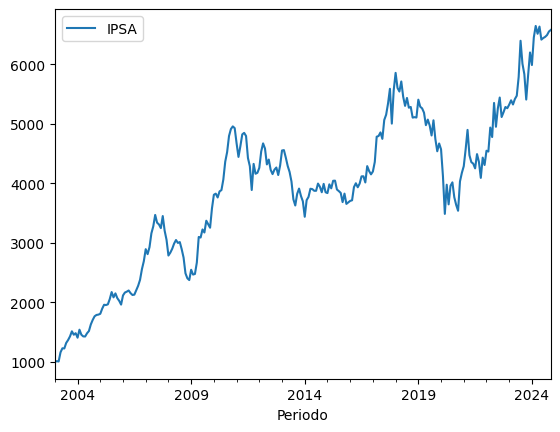

In [5]:
# Seteo de fecha como indice
df_IPSA.set_index('Periodo', inplace=True)

# renombre de columna
df_IPSA.rename(columns={'1.IPSA  (índice enero 2003=1000)                      ':'IPSA'}, inplace=True)

# Escalamiento para modelo
scaler = MinMaxScaler(feature_range=(0, 1))
df_IPSA['Escalado'] = scaler.fit_transform(df_IPSA[['IPSA']])
df_IPSA.plot(y='IPSA')


### Análisis de la serie de tiempo

La data presenta una clara tendencia alcista, pero también muestra una volatilidad significativa, que podría estar relacionada con eventos mundiales como la crisis de 2008, el estallido social y la pandemia de COVID-19, considerando los períodos en los que se observan cambios abruptos.  
Si bien no hay una estacionalidad inmediatamente evidente, podrían existir patrones anuales al analizar el espectro diferencial.


### Elección de parametros y diseño del modelo 

In [6]:
retrasos = 3 #Numero de columnas de retrazo a crear

for i in range(1, retrasos + 1):
    df_IPSA[f'lag_{i}'] = df_IPSA['Escalado'].shift(i)
    
df_IPSA['Objetivo'] = df_IPSA['Escalado']
df_IPSA.dropna(inplace=True)  # Drop Nans


In [7]:
X = df_IPSA[[col for col in df_IPSA.columns if col.startswith('lag')]].values
y = df_IPSA['Objetivo'].values

Se le da el formato requerido por el modelo LSTM a los datos.  


In [8]:
X = X.reshape((X.shape[0], X.shape[1], 1))


Se separan los datos en entrenamiento y testeo

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #Shuffle false es importante para mantener el orden de la serie de tiempo


Diseñamos la arquitectura del modelo; en este caso, es un modelo LSTM simple.  


In [10]:


# Crear el LSTM modelo
model = Sequential()
model.add(Input((X_train.shape[1], 1)))
model.add(LSTM(units=500, activation='relu', return_sequences=False))
model.add(Dense(units=1))

# Compilar el Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen de modelo
model.summary()


I0000 00:00:1734402108.215401  225719 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 500)            │     1,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,501 (3.83 MB)

 Trainable params: 1,004,501 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

history = model.fit(X_train, y_train, epochs=500, batch_size=256, verbose=0)


I0000 00:00:1734402110.471977  225829 service.cc:148] XLA service 0x7f09dc0054b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734402110.472014  225829 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-16 23:21:50.500683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734402110.638249  225829 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734402111.226439  225829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


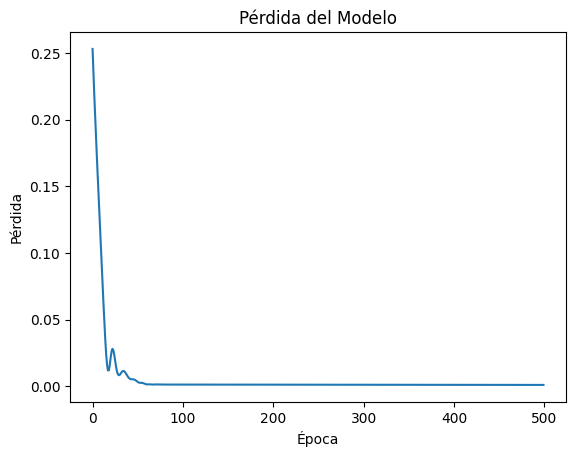

In [12]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'])


# Añadir etiquetas y título
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

### Validación y cálculo de métricas.  


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


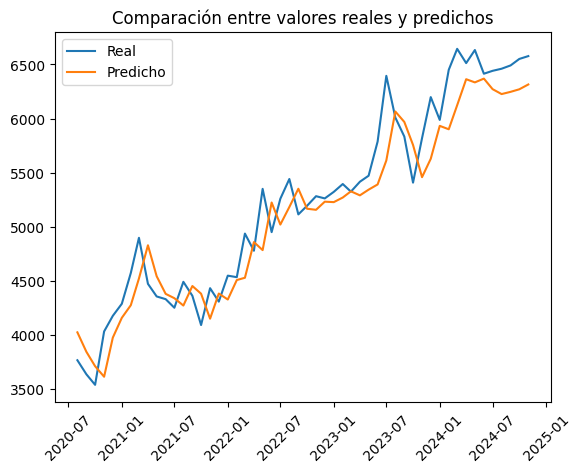

In [13]:

predicciones = model.predict(X_test)


predicciones_reescalado = scaler.inverse_transform(predicciones)
y_test_rescalado = scaler.inverse_transform(y_test.reshape(-1, 1))

dates = list(df_IPSA[int(len(df_IPSA)*0.8):].index)

plt.xticks(rotation=45)
plt.title('Comparación entre valores reales y predichos')
plt.plot(dates,y_test_rescalado, label='Real')
plt.plot(dates,predicciones_reescalado, label='Predicho')
plt.legend()
plt.show()


In [14]:
mae_IPSA = mean_absolute_error(y_test_rescalado,predicciones_reescalado)
mse_IPSA = mean_squared_error(y_test_rescalado,predicciones_reescalado)
r2_IPSA = r2_score(y_test_rescalado,predicciones_reescalado)

n = len(y_test)
p = X_train.shape[1] # numero de features (en este caso lags)

adjusted_r2_IPSA = 1 - ((1 - r2_IPSA) * (n - 1)) / (n - p - 1)

print(f"Mean Absolute Error (MAE): {mae_IPSA:.1f}")
print(f"Mean Squared Error (MSE): {mse_IPSA:.1f}")
print(f"Root Mean Squared Error (RMSE): {mse_IPSA**0.5:.1f}")
print(f"R² ajustado: {adjusted_r2_IPSA:.3f}")

Mean Absolute Error (MAE): 233.1
Mean Squared Error (MSE): 81065.2
Root Mean Squared Error (RMSE): 284.7
R² ajustado: 0.892


In [15]:
#Obtener el valor del ultimo dato y darle formato que espera el modelo
last_data = df_IPSA[[col for col in df_IPSA.columns if col.startswith('lag')]].iloc[-1:].values.reshape(1, X.shape[1], 1) 

In [16]:
#prediccion de los siguientes n meses
n_meses = 3
prediccion_n_meses = []
for i in range(n_meses):
    predicciones2 = model.predict(last_data)
    last_data = np.roll(last_data, -1)
    last_data[0][-1] = predicciones2
    prediccion_n_meses.append(predicciones2[0])

print("Los valores de los proximos 3 meses seran:", scaler.inverse_transform(prediccion_n_meses).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Los valores de los proximos 3 meses seran: [6314.43276797 6270.98258519 6213.361072  ]


In [17]:
dates_extended = pd.date_range(dates[-1] + pd.DateOffset(months=1), periods=3, freq='MS')
dates_extended = [pd.Timestamp(date) for date in dates_extended]
dates_extended=dates+dates_extended

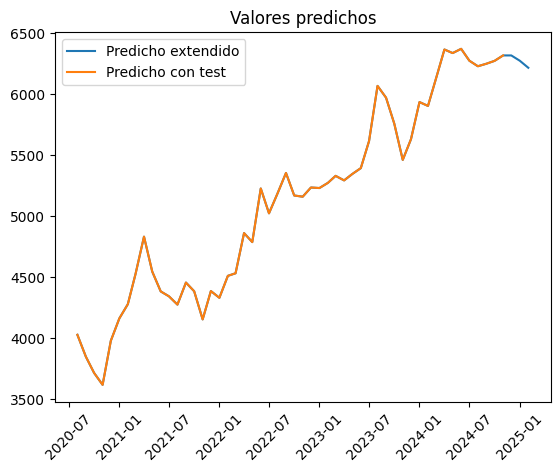

In [18]:

plt.plot(dates_extended,scaler.inverse_transform(np.concat((predicciones,last_data[0]))), label='Predicho extendido', )
plt.plot(dates,scaler.inverse_transform((predicciones)), label='Predicho con test')

plt.legend()
plt.title("Valores predichos")
plt.xticks(rotation=45)
plt.show()

## Produccion de Leche

### Preparación y Carga de la Data

In [19]:
df_leche = pd.read_csv(r'./data/monthly_milk_production.csv')

In [20]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [21]:
df_leche.tail()

,Date,Production
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797
167,1975-12,843


In [22]:
df_leche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


**Importante** No hay valores nulos que necesiten evaluación.

### Visualización de la data

In [23]:
df_leche['Date'] = pd.to_datetime(df_leche['Date'])
# Renombre de columnas
df_leche.rename(columns={'Production': 'Produccion', 'Date': 'Fecha'}, inplace=True)

# Seteo de fecha como indice
df_leche.set_index('Fecha', inplace=True)


# Escalamiento para modelo
scaler = MinMaxScaler(feature_range=(0, 1))
df_leche['Escalado'] = scaler.fit_transform(df_leche[['Produccion']])



<Axes: title={'center': 'Producción de leche entre 1962 y 1974'}, xlabel='Fecha', ylabel='Libras'>

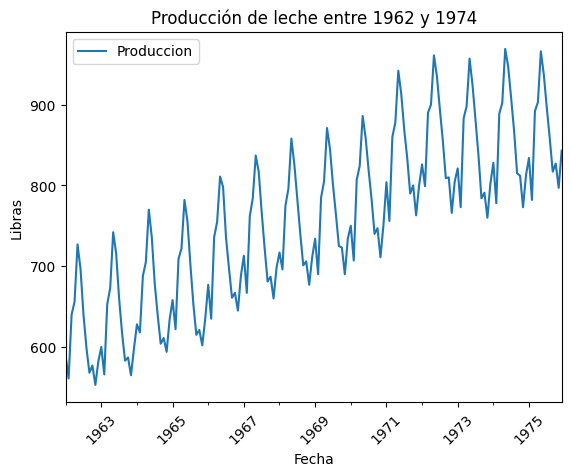

In [24]:
df_leche.plot(y='Produccion', title='Producción de leche entre 1962 y 1974', rot=45, ylabel='Libras' )


### Análisis de la serie de tiempo

La data presenta una clara tendencia creciente antes de 1971 y parece estabilizarse desde entonces. Además, se puede observar que existe una fuerte componente estacional, que domina la producción dentro de cada año.


### Elección de parametros y diseño del modelo 

In [25]:
retrasos = 8 #Numero de columnas de retrazo a crear

for i in range(1, retrasos + 1):
    df_leche[f'lag_{i}'] = df_leche['Escalado'].shift(i)
    
df_leche['Objetivo'] = df_leche['Escalado']
df_leche.dropna(inplace=True)  # Drop Nans


In [26]:
X_leche = df_leche[[col for col in df_leche.columns if col.startswith('lag')]].values
y_leche = df_leche['Objetivo'].values

Se le da el formato requerido por el modelo LSTM a los datos.  


In [27]:
X_leche = X_leche.reshape((X_leche.shape[0], X_leche.shape[1], 1))


Se separan los datos en entrenamiento y testeo

In [28]:
X_leche_train, X_leche_test, y_leche_train, y_leche_test = train_test_split(X_leche, y_leche, test_size=0.3, shuffle=False) #Shuffle false es importante para mantener el orden de la serie de tiempo


Diseñamos la arquitectura del modelo; en este caso, es un modelo LSTM simple.  


In [29]:


# Crear el LSTM modelo
model = Sequential()
model.add(Input((X_leche_train.shape[1], 1)))
model.add(LSTM(units=500, activation='relu', return_sequences=False))
model.add(Dense(units=1))

# Compilar el Modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen de modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 500)            │     1,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,501 (3.83 MB)

 Trainable params: 1,004,501 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:

history_leche = model.fit(X_leche_train, y_leche_train, epochs=500, batch_size=256, verbose=0)


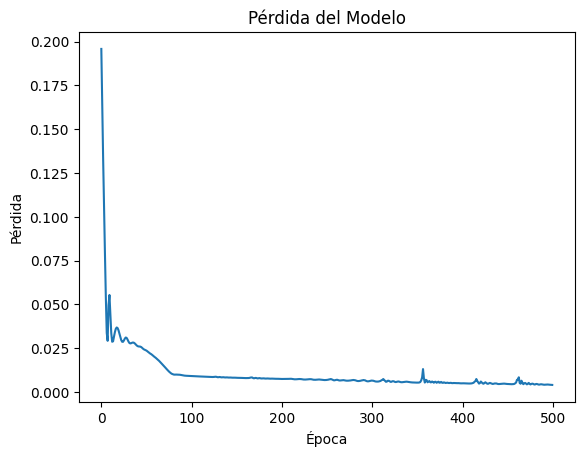

In [31]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history_leche.history['loss'])


# Añadir etiquetas y título
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

### Validación y cálculo de métricas.  


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


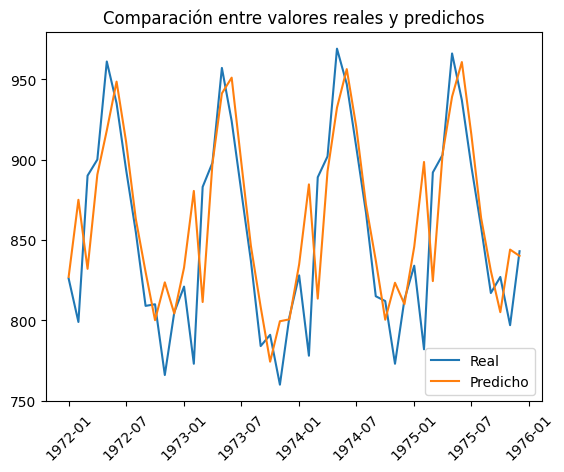

In [32]:

predicciones_leche = model.predict(X_leche_test)


predicciones_leche_reescalado = scaler.inverse_transform(predicciones_leche)
y_leche_test_rescalado = scaler.inverse_transform(y_leche_test.reshape(-1, 1))

dates_leche = list(df_leche[int(len(df_leche)*0.7):].index)

fig, ax = plt.subplots()

plt.xticks(rotation=45)
plt.title('Comparación entre valores reales y predichos')
plt.plot(dates_leche,y_leche_test_rescalado, label='Real')
plt.plot(dates_leche,predicciones_leche_reescalado, label='Predicho')
plt.legend()

plt.show()


In [33]:
mae_leche = mean_absolute_error(y_leche_test_rescalado,predicciones_leche_reescalado)
mse_leche = mean_squared_error(y_leche_test_rescalado,predicciones_leche_reescalado)
r2_leche = r2_score(y_leche_test_rescalado,predicciones_leche_reescalado)

n = len(y_leche_test)
p = X_leche_train.shape[1] # numero de features (en este caso lags)

adjusted_r2_leche = 1 - ((1 - r2_leche) * (n - 1)) / (n - p - 1)

print(f"Mean Absolute Error (MAE): {mae_leche:.1f}")
print(f"Mean Squared Error (MSE): {mse_leche:.1f}")
print(f"Root Mean Squared Error (RMSE): {mse_leche**0.5:.1f}")
print(f"R² ajustado: {adjusted_r2_leche:.3f}")

Mean Absolute Error (MAE): 28.5
Mean Squared Error (MSE): 1687.0
Root Mean Squared Error (RMSE): 41.1
R² ajustado: 0.429


In [34]:
#Obtener el valor del ultimo dato y darle formato que espera el modelo
last_data_leche = df_leche[[col for col in df_leche.columns if col.startswith('lag')]].iloc[-1:].values.reshape(1, X_leche.shape[1], 1) 

In [35]:
#prediccion de los siguientes n meses
n_meses = 3
prediccion_n_meses_leche = []
for i in range(n_meses):
    predicciones2_leche = model.predict(last_data_leche)
    last_data_leche = np.roll(last_data_leche, -1)
    last_data_leche[0][-1] = predicciones2_leche
    prediccion_n_meses_leche.append(predicciones2_leche[0])

print("Los valores de los proximos 3 meses seran:", scaler.inverse_transform(prediccion_n_meses_leche).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Los valores de los proximos 3 meses seran: [840.08071327 836.79257774 805.21923637]


In [36]:
dates_extended = pd.date_range(dates_leche[-1] + pd.DateOffset(months=1), periods=3, freq='MS')
dates_extended = [pd.Timestamp(date) for date in dates_extended]
dates_extended=dates_leche+dates_extended

In [37]:
prediccion_n_meses_leche[0]

array([0.69009787], dtype=float32)

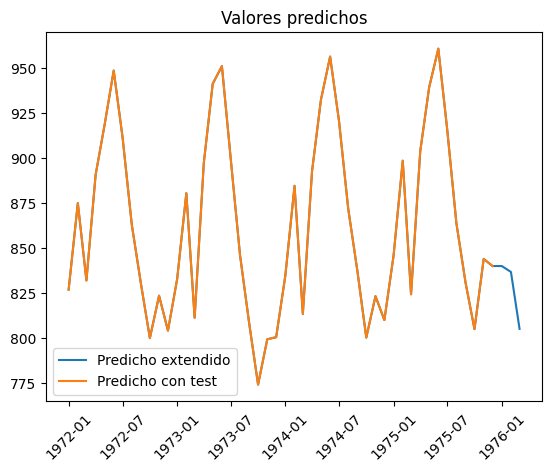

In [38]:

plt.plot(dates_extended,scaler.inverse_transform(np.concat((predicciones_leche,prediccion_n_meses_leche))), label='Predicho extendido', )
plt.plot(dates_leche,predicciones_leche_reescalado, label='Predicho con test')

plt.legend()
plt.title("Valores predichos")
plt.xticks(rotation=45)
plt.show()